This is the code for the wastewater prediction portion of our CWDS system. Here we select the county or multiple counties to predict the previlence of covid within the given comunity or communities.

# **Installing nessisary packages**

This code both requires darts which most systems do not have installed and the newest version of matplotlib to allow for it to visualize.

In [ ]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp39-cp39-linux_x86_64.whl size=12062416 sha256=04851f496d0d15c74bc97ceab2c2158d1a26c2677d2ce4fce509d8ae750e2b47
  Stored in directory: /root/.cache/pip/wheels/88/5f/33/d7b8943eba74fdfbd535c83cefcf366c25b0f9cb6424e763e7
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.1.3 which is incompatible.
pandas-profiling 3.2.0 requires

In [ ]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.

# **Loading in all relivant packages and the data**

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from torch.utils.tensorboard import SummaryWriter
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts import TimeSeries, concatenate
from darts.models import TCNModel, RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.models import TransformerModel, NBEATSModel, TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score, mase, mae, marre, coefficient_of_variation, smape
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood, PoissonLikelihood
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from darts.dataprocessing.transformers import MissingValuesFiller

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

cases_data = pd.read_csv('https://raw.githubusercontent.com/biobotanalytics/covid19-wastewater-data/master/cases_by_county.csv', encoding="utf-8-sig")
viral_data = pd.read_csv('https://raw.githubusercontent.com/biobotanalytics/covid19-wastewater-data/master/wastewater_by_county.csv', encoding="utf-8-sig")
viral_data['date'] = viral_data['sampling_week']
penn_rest = pd.read_csv('https://raw.githubusercontent.com/mehrdadfazli/COVID-SEIR/main/Data/penn-rest.csv')
usa_facts = pd.read_csv('https://raw.githubusercontent.com/Shakeri-Lab/COVID-SEIR/main/Data/covid_confirmed_usafacts.csv')

train_test_ratio = 0.8
train_val_ratio  = 0.9

**Note:** Make sure to save the pretrained models on your machine and change the path to model checkpoints accordingly.

In [ ]:
cases_data

,date,rolling_average_cases_per_100k,region,state,name,fipscode
0,2020-01-26,0.000000,South,AL,"St. Clair County, AL",1115
1,2020-02-08,0.000000,South,AL,"St. Clair County, AL",1115
2,2020-02-18,0.000000,South,AL,"St. Clair County, AL",1115
3,2020-02-19,0.000000,South,AL,"St. Clair County, AL",1115
4,2020-02-23,0.000000,South,AL,"St. Clair County, AL",1115
...,...,...,...,...,...,...
288745,2020-04-25,1.217671,West,WY,"Teton County, WY",56039
288746,2020-04-28,0.608835,West,WY,"Teton County, WY",56039
288747,2020-04-29,1.217671,West,WY,"Teton County, WY",56039
288748,2020-05-06,0.608835,West,WY,"Teton County, WY",56039


In [ ]:
mapping = {cases_data.columns[0]: 'date', cases_data.columns[1]:'rolling_average_cases_per_100k', cases_data.columns[2]:'region', cases_data.columns[3]:'state', cases_data.columns[4]:'name', cases_data.columns[5]:'zipcode'}
cases_data = cases_data.rename(columns=mapping)

In [ ]:
cases_data

,date,rolling_average_cases_per_100k,region,state,name,zipcode
0,2020-01-26,0.000000,South,AL,"St. Clair County, AL",1115
1,2020-02-08,0.000000,South,AL,"St. Clair County, AL",1115
2,2020-02-18,0.000000,South,AL,"St. Clair County, AL",1115
3,2020-02-19,0.000000,South,AL,"St. Clair County, AL",1115
4,2020-02-23,0.000000,South,AL,"St. Clair County, AL",1115
...,...,...,...,...,...,...
288745,2020-04-25,1.217671,West,WY,"Teton County, WY",56039
288746,2020-04-28,0.608835,West,WY,"Teton County, WY",56039
288747,2020-04-29,1.217671,West,WY,"Teton County, WY",56039
288748,2020-05-06,0.608835,West,WY,"Teton County, WY",56039


In [ ]:
viral_data

,sampling_week,effective_concentration_rolling_average,region,state,name,fipscode,date
0,2020-01-15,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-15
1,2020-01-22,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-22
2,2020-01-29,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-29
3,2020-02-05,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-02-05
4,2020-02-12,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-02-12
...,...,...,...,...,...,...,...
14798,2023-03-29,542.190920,South,VA,"Wise County, VA",51195,2023-03-29
14799,2023-03-29,301.697901,Midwest,IA,"Woodbury County, IA",19193,2023-03-29
14800,2023-03-29,312.867120,Northeast,MA,"Worcester County, MA",25027,2023-03-29
14801,2023-03-29,317.466861,West,AZ,"Yavapai County, AZ",4025,2023-03-29


In [ ]:
mapping = {viral_data.columns[0]: 'sampling_week', viral_data.columns[1]:'effective_concentration_rolling_average', viral_data.columns[2]:'region', viral_data.columns[3]:'state', viral_data.columns[4]:'name', viral_data.columns[5]:'zipcode', viral_data.columns[6]:'date'}
viral_data = viral_data.rename(columns=mapping)

In [ ]:
viral_data

,sampling_week,effective_concentration_rolling_average,region,state,name,zipcode,date
0,2020-01-15,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-15
1,2020-01-22,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-22
2,2020-01-29,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-29
3,2020-02-05,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-02-05
4,2020-02-12,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-02-12
...,...,...,...,...,...,...,...
14798,2023-03-29,542.190920,South,VA,"Wise County, VA",51195,2023-03-29
14799,2023-03-29,301.697901,Midwest,IA,"Woodbury County, IA",19193,2023-03-29
14800,2023-03-29,312.867120,Northeast,MA,"Worcester County, MA",25027,2023-03-29
14801,2023-03-29,317.466861,West,AZ,"Yavapai County, AZ",4025,2023-03-29


## **Utils**

In [ ]:
def mape_calc(backtest_series, actual_series, transformer):
    return(mape(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def mae_calc(backtest_series, actual_series, transformer):
    return(mae(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def mase_calc(backtest_series, actual_series, insample_series, transformer):
    return(mase(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series), insample_series))

def r2_score_calc(backtest_series, actual_series, transformer):
    return(r2_score(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def marre_calc(backtest_series, actual_series, transformer):
    return(marre(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def cov_calc(backtest_series, actual_series, transformer):
    return(coefficient_of_variation(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

def smape_calc(backtest_series, actual_series, transformer):
    return(smape(transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series)))

In [ ]:
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd
from torch import Tensor

from darts import TimeSeries
from darts.explainability.explainability import (
    ExplainabilityResult,
    ForecastingModelExplainer,
)
from darts.models import TFTModel
from pytorch_lightning.callbacks import Callback


class TFTExplainer(ForecastingModelExplainer):
    def __init__(
        self,
        model: TFTModel,
    ):
        """
        Explainer class for the TFT model.
        Parameters
        ----------
        model
            The fitted TFT model to be explained.
        """
        super().__init__(model)

        if not model._fit_called:
            raise ValueError("The model needs to be trained before explaining it.")

        self._model = model

    @property
    def encoder_importance(self):
        return self._get_importance(self,
            weight=self._model.model._encoder_sparse_weights,
            names=self._model.model.encoder_variables,
        )

    @property
    def decoder_importance(self):
        return self._get_importance(self,
            weight=self._model.model._decoder_sparse_weights,
            names=self._model.model.decoder_variables,
        )

    def get_variable_selection_weight(self, plot=False) -> Dict[str, pd.DataFrame]:
        """Returns the variable selection weight of the TFT model.
        Parameters
        ----------
        plot
            Whether to plot the variable selection weight.
        Returns
        -------
        TimeSeries
            The variable selection weight.
        """

        if plot:
            # plot the encoder and decoder weights
            self._plot_cov_selection(
                self.encoder_importance,
                title="Encoder variable importance",
            )
            self._plot_cov_selection(
                self.decoder_importance,
                title="Decoder variable importance",
            )

        return {
            "encoder_importance": self.encoder_importance,
            "decoder_importance": self.decoder_importance,
        }

    def explain(self, **kwargs) -> ExplainabilityResult:
        """Returns the explainability result of the TFT model.
        The explainability result contains the attention heads of the TFT model.
        The attention heads determine the contribution of time-varying inputs.
        Parameters
        ----------
        kwargs
            Arguments passed to the `predict` method of the TFT model.
        Returns
        -------
        ExplainabilityResult
            The explainability result containing the attention heads.
        """
        super().explain()
        # without the predict call, the weights will still bet set to the last iteration of the forward() method
        # of the _TFTModule class
        if "n" not in kwargs:
            kwargs["n"] = self._model.model.output_chunk_length

        _ = self._model.predict(**kwargs)

        # get the weights and the attention head from the trained model for the prediction
        attention_heads = (
            self._model.model._attn_out_weights.squeeze().sum(axis=1).detach()
        )

        # return the explainer result to be used in other methods
        return ExplainabilityResult(
            {
                0: {
                    "attention_heads": TimeSeries.from_dataframe(
                        pd.DataFrame(attention_heads).transpose()
                    ),
                }
            },
        )

    @staticmethod

    def _get_importance(
        self,
        weight: Tensor,
        names: List[str],
        n_decimals=3,
    ) -> pd.DataFrame:
        """Returns the encoder or decoder variable of the TFT model.
        Parameters
        ----------
        weights
            The weights of the encoder or decoder of the trained TFT model.
        names
            The encoder or decoder names saved in the TFT model class.
        n_decimals
            The number of decimals to round the importance to.
        Returns
        -------
        pd.DataFrame
            The importance of the variables.
        """
        # transform the encoder/decoder weights to percentages, rounded to n_decimals
        weights_percentage = (
            weight.mean(axis=1).detach().numpy().mean(axis=0).round(n_decimals) * 100
        )

        # create a dataframe with the variable names and the weights
        name_mapping = self._name_mapping
        importance = pd.DataFrame(
            weights_percentage,
            columns=[name_mapping[name] for name in names],
        )

        # return the importance sorted descending
        return importance.transpose().sort_values(0, ascending=False).transpose()

    @property
    def _name_mapping(self) -> Dict[str, str]:
        """Returns the feature name mapping of the TFT model.
        Returns
        -------
        Dict[str, str]
            The feature name mapping. For example
            {
                'past_covariate_0': 'heater',
                'past_covariate_1': 'year',
                'past_covariate_2': 'month',
                'future_covariate_0': 'darts_enc_fc_cyc_month_sin',
                'future_covariate_1': 'darts_enc_fc_cyc_month_cos',
                'target_0': 'ice cream',
             }
        """
        past_covariates_name_mapping = {
            f"past_covariate_{i}": colname
            for i, colname in enumerate(self._model.past_covariate_series.components)
        }
        future_covariates_name_mapping = {
            f"future_covariate_{i}": colname
            for i, colname in enumerate(self._model.future_covariate_series.components)
        }
        target_name_mapping = {
            f"target_{i}": colname
            for i, colname in enumerate(self._model.training_series.components)
        }

        return {
            **past_covariates_name_mapping,
            **future_covariates_name_mapping,
            **target_name_mapping,
        }

    @staticmethod
    def _plot_cov_selection(
        importance: pd.DataFrame, title: str = "Variable importance"
    ):
        """Plots the variable importance of the TFT model.
        Parameters
        ----------
        importance
            The encoder / decoder importance.
        title
            The title of the plot.
        """
        fig = plt.figure()
        plt.bar(importance.columns.tolist(), importance.values[0].tolist(), figure=fig)
        plt.title(title)
        plt.xlabel("Variable", fontsize=12)
        plt.ylabel("Variable importance in %")
        plt.show()

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))

## **County Class**
Here we define a county class which stores all the information on a county-level including cases, viral load data and covariates. The set_timeseries method scales, fills in missing values, and splits the time series into train and test.

In [ ]:
class county:
  
    def __init__(self, county):
        self.county = county

    def set_timeseries(self, cases, viral, covars, end_date=None, fill_daily=False):
        
        if fill_daily:
            fill_frq = 'D'
        else:
            fill_frq = 'W-WED'
        
        if not end_date:
            end_date = dt.datetime.today()

        self.state = cases.loc[cases['name'] == self.county]['state'].values[0]

        cases_df = cases.loc[cases['name'] == self.county]
        viral_df = viral.loc[viral['name'] == self.county]
        covars_df = covars.loc[covars['state'] == self.state]

        self.date = list(set(list(cases_df['date'])) & set(list(covars_df['date'])))

        cases_df  = cases_df.loc[cases_df['date'].isin(self.date)]
        viral_df  = viral_df.loc[viral_df['date'].isin(self.date)]
        covars_df = covars_df.loc[covars_df['date'].isin(self.date)]
        
        covars_df['date']= pd.to_datetime(covars_df['date'])
        cases_df['date'] = pd.to_datetime(cases_df['date'])
        viral_df['date'] = pd.to_datetime(viral_df['date'])
        
        cases_df = cases_df.loc[(cases_df['date'] >= min(viral_df['date'])) & 
                                (cases_df['date'] <= max(viral_df['date'])) &
                                (cases_df['date'] < end_date)]
        covars_df = covars_df.loc[(covars_df['date'] >= min(viral_df['date'])) &
                                  (covars_df['date'] < end_date)]
        viral_df = viral_df.loc[(viral_df['date'] < end_date)]

        covars_df = covars_df.set_index('date')
        cases_df['date'] = pd.to_datetime(cases_df['date'])
        cases_df = cases_df.set_index('date')

        viral_df = viral_df.set_index('date')    

        self.cases         = TimeSeries.from_series(cases_df['rolling_average_cases_per_100k'], fill_missing_dates=True, freq=fill_frq, )
        self.cases_scalers = Scaler()
        self.cases_transformer = MissingValuesFiller()
        self.cases_scaled  = self.cases_scalers.fit_transform(self.cases_transformer.transform(self.cases))
        self.cases_scaled_train, self.cases_scaled_test = self.cases_scaled.split_after(train_test_ratio)
        self.cases_scaled_train, self.cases_scaled_val  = self.cases_scaled_train.split_after(train_val_ratio)


        self.viral         = TimeSeries.from_series(viral_df['effective_concentration_rolling_average'], fill_missing_dates=True, freq=fill_frq)
        self.viral_scalers = Scaler()
        self.viral_transformer = MissingValuesFiller()
        self.viral_scaled  = self.viral_scalers.fit_transform(self.viral_transformer.transform(self.viral))
        self.viral_scaled_train, self.viral_scaled_test = self.viral_scaled.split_after(train_test_ratio)
        self.viral_scaled_train, self.viral_scaled_val  = self.viral_scaled_train.split_after(train_val_ratio)

        stringency_ts      = TimeSeries.from_series(covars_df['StringencyIndex_Average'], fill_missing_dates=True, freq=fill_frq)
        govresp_ts         = TimeSeries.from_series(covars_df['GovernmentResponseIndex_Average'], fill_missing_dates=True, freq=fill_frq)
        containH_ts        = TimeSeries.from_series(covars_df['ContainmentHealthIndex_Average'], fill_missing_dates=True, freq=fill_frq)
        econSupp_ts        = TimeSeries.from_series(covars_df['EconomicSupportIndex'], fill_missing_dates=True, freq=fill_frq)
        
        self.covars = govresp_ts.stack(stringency_ts).stack(containH_ts).stack(econSupp_ts)
        
        year_covar    = (datetime_attribute_timeseries(self.covars, attribute="year", one_hot=False)-2020)/2
        month_covar   = datetime_attribute_timeseries(self.covars, attribute="month", one_hot=False)/12
        week_covar    = datetime_attribute_timeseries(self.covars, attribute="week", one_hot=False)/52
        dayOfW_covar  = datetime_attribute_timeseries(self.covars, attribute="dayofweek", one_hot=False)/6

        self.covars = self.covars.stack(year_covar).stack(month_covar).stack(week_covar).stack(dayOfW_covar)
        covars_transformer = MissingValuesFiller()
        self.covars = covars_transformer.transform(self.covars)

In [ ]:
viral_data

,sampling_week,effective_concentration_rolling_average,region,state,name,zipcode,date
0,2020-01-15,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-15
1,2020-01-22,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-22
2,2020-01-29,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-01-29
3,2020-02-05,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-02-05
4,2020-02-12,0.000000,Northeast,MA,"Suffolk County, MA",25025,2020-02-12
...,...,...,...,...,...,...,...
14798,2023-03-29,542.190920,South,VA,"Wise County, VA",51195,2023-03-29
14799,2023-03-29,301.697901,Midwest,IA,"Woodbury County, IA",19193,2023-03-29
14800,2023-03-29,312.867120,Northeast,MA,"Worcester County, MA",25027,2023-03-29
14801,2023-03-29,317.466861,West,AZ,"Yavapai County, AZ",4025,2023-03-29


In [ ]:
cases_data

,date,rolling_average_cases_per_100k,region,state,name,zipcode
0,2020-01-26,0.000000,South,AL,"St. Clair County, AL",1115
1,2020-02-08,0.000000,South,AL,"St. Clair County, AL",1115
2,2020-02-18,0.000000,South,AL,"St. Clair County, AL",1115
3,2020-02-19,0.000000,South,AL,"St. Clair County, AL",1115
4,2020-02-23,0.000000,South,AL,"St. Clair County, AL",1115
...,...,...,...,...,...,...
288745,2020-04-25,1.217671,West,WY,"Teton County, WY",56039
288746,2020-04-28,0.608835,West,WY,"Teton County, WY",56039
288747,2020-04-29,1.217671,West,WY,"Teton County, WY",56039
288748,2020-05-06,0.608835,West,WY,"Teton County, WY",56039


## **Covariates**

Here the original authors wanted to demonstrate the slow decrease in the covid policies by state, they use the word Covariates to describe them. At this point we can add covariates including government responses, stringency index, and econimic support. The data is collected by the University of Oxford [here](https://github.com/OxCGRT/covid-policy-tracker).

In [ ]:
oxford_covar = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/United%20States/OxCGRT_USA_latest.csv')
oxford_covar = oxford_covar[['Date', 'RegionName', 'RegionCode', 'StringencyIndex_Average', 
                            'GovernmentResponseIndex_Average', 'ContainmentHealthIndex_Average', 
                             'EconomicSupportIndex']]

oxford_covar = oxford_covar.astype({'Date': str})
oxford_covar['date'] = oxford_covar['Date'].apply(lambda L: L[:4] + '-' + L[4:6] + '-' + L[6:])
oxford_covar['StringencyIndex_Average'] /= 100
oxford_covar['GovernmentResponseIndex_Average'] /= 100
oxford_covar['ContainmentHealthIndex_Average'] /= 100
oxford_covar['EconomicSupportIndex'] /= 100

oxford_covar = oxford_covar.dropna(subset=['RegionCode'])
oxford_covar['state'] = oxford_covar['RegionCode'].apply(lambda L: L[3:])

In [ ]:
oxford_covar

,Date,RegionName,RegionCode,StringencyIndex_Average,GovernmentResponseIndex_Average,ContainmentHealthIndex_Average,EconomicSupportIndex,date,state
1096,20200101,Alaska,US_AK,NaN,NaN,NaN,NaN,2020-01-01,AK
1097,20200102,Alaska,US_AK,NaN,NaN,NaN,NaN,2020-01-02,AK
1098,20200103,Alaska,US_AK,NaN,NaN,NaN,NaN,2020-01-03,AK
1099,20200104,Alaska,US_AK,NaN,NaN,NaN,NaN,2020-01-04,AK
1100,20200105,Alaska,US_AK,NaN,NaN,NaN,NaN,2020-01-05,AK
...,...,...,...,...,...,...,...,...,...
56987,20221227,Wyoming,US_WY,0.2337,0.3085,0.3526,0.0,2022-12-27,WY
56988,20221228,Wyoming,US_WY,0.2337,0.3085,0.3526,0.0,2022-12-28,WY
56989,20221229,Wyoming,US_WY,0.2337,0.3085,0.3526,0.0,2022-12-29,WY
56990,20221230,Wyoming,US_WY,0.2337,0.3085,0.3526,0.0,2022-12-30,WY


In [ ]:
cases_data['name'].unique()

array(['St. Clair County, AL', 'Lonoke County, AR',
       'Mississippi County, AR', 'Sonoma County, CA', 'DeKalb County, GA',
       'Skagit County, WA', 'Snohomish County, WA', 'Boone County, AR',
       'Garland County, AR', 'Greene County, AR', 'Hempstead County, AR',
       'Ouachita County, AR', 'Pulaski County, AR', 'Lee County, AL',
       'City and Borough of Juneau, AK', 'La Paz County, AZ',
       'Maricopa County, AZ', 'Mohave County, AZ', 'Pima County, AZ',
       'Benton County, AR', 'Colbert County, AL',
       'Hillsborough County, FL', 'Palm Beach County, FL',
       'Pinellas County, FL', 'Hawaii County, HI', 'Honolulu County, HI',
       'Kauai County, HI', 'Escambia County, AL', 'Madison County, AL',
       'Shelby County, AL', 'Yavapai County, AZ', 'Ada County, ID',
       'Winnebago County, IL', 'Allen County, IN', 'Benton County, IN',
       'Ripley County, IN', 'St. Joseph County, IN',
       'Jefferson County, AR', 'Pope County, AR', 'Washington County, AR',
  

Here we define the target counties, we can choose multiple but in this code we chose Union county alone for this demo. 

In [ ]:
target_counties = ['Union County, NJ']
end_dates = [dt.datetime.fromisoformat('2022-12-05'),]

counties_instances = []

for i in range(len(target_counties)):
    print(target_counties[i])
    counties_instances.append(county(target_counties[i]))
    counties_instances[i].set_timeseries(cases_data, viral_data, oxford_covar, end_dates[i], fill_daily=True)

print(len(target_counties), len(end_dates))

Union County, NJ
1 1


Now we make a list of training and covariate timeseries

In [ ]:
# with viral load

train_list_ts = []
val_list_ts   = []
test_list_ts  = []
past_covar_ts = []
fut_covar_ts  = []
past_only_covar_ts = []
full_ts = []
county_names = []

for i in range(len(target_counties)):
    county_names.append(counties_instances[i].county[:-11])
    full_ts.append(counties_instances[i].cases_scaled)
    train_list_ts.append(counties_instances[i].cases_scaled_train)
    val_list_ts.append(counties_instances[i].cases_scaled_val)
    test_list_ts.append(counties_instances[i].cases_scaled_test)
    fut_covar_ts.append(counties_instances[i].covars)
    past_only_covar_ts.append(counties_instances[i].viral_scaled)
    past_covar_ts.append(counties_instances[i].covars.split_before(len(counties_instances[i].viral_scaled))[0].stack(counties_instances[i].viral_scaled))

## Visualization of the processed data

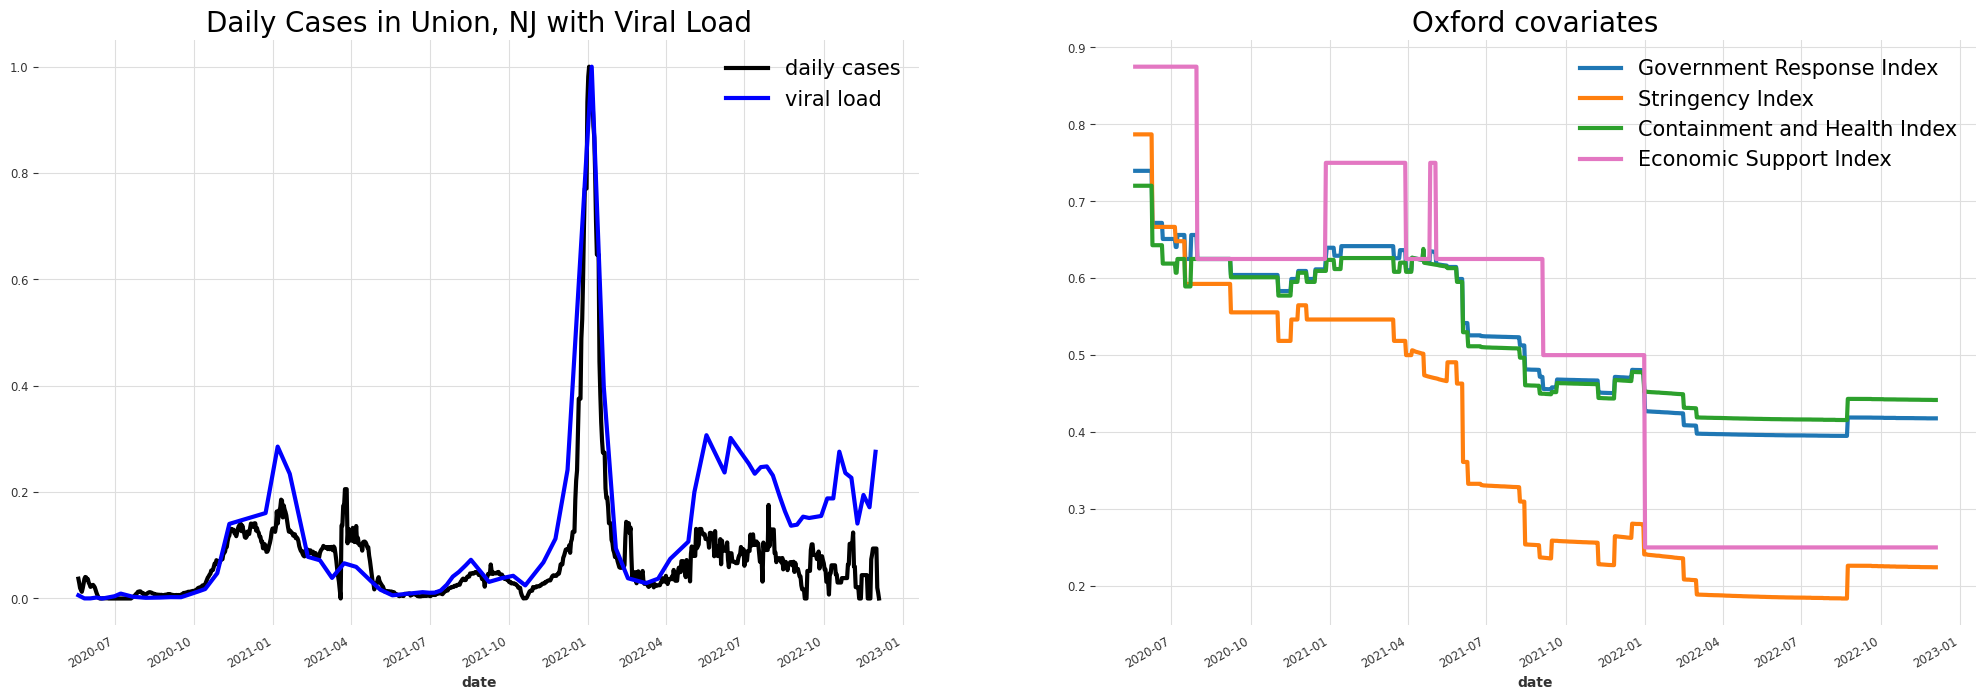

In [ ]:
k=0
fig, axes = plt.subplots(1, 2, figsize = (25, 9))
plt.rcParams.update({'font.size': 30, 'font.weight':'normal', 'font.family': 'times new roman'})
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.8, wspace=None, hspace=0.4)

counties_instances[k].cases_scaled.plot(label='Daily Cases', ax=axes[0], linewidth=3, color='black')
counties_instances[k].viral_scaled.plot(label='Viral Load',  ax=axes[0], linewidth=3, color='blue')
axes[0].set_title('Daily Cases in Union, NJ with Viral Load', fontsize=20)
axes[0].legend(['daily cases', 'viral load'], fontsize=15)

counties_instances[k].covars['GovernmentResponseIndex_Average'].plot(label='Government Response Index', ax=axes[1], color='tab:blue', linewidth=3)
counties_instances[k].covars['StringencyIndex_Average'].plot(label='Stringency Index', ax=axes[1], color='tab:orange', linewidth=3)
counties_instances[k].covars['ContainmentHealthIndex_Average'].plot(label='Containment and Health Index', ax=axes[1], color='tab:green', linewidth=3)
counties_instances[k].covars['EconomicSupportIndex'].plot(label='Economic Support Index', ax=axes[1], color='tab:pink', linewidth=3)
axes[1].set_title('Oxford covariates', fontsize=20)
axes[1].legend(['Government Response Index', 'Stringency Index', 'Containment and Health Index', 'Economic Support Index'], fontsize=15)

plt.gcf().subplots_adjust(bottom=0.15)

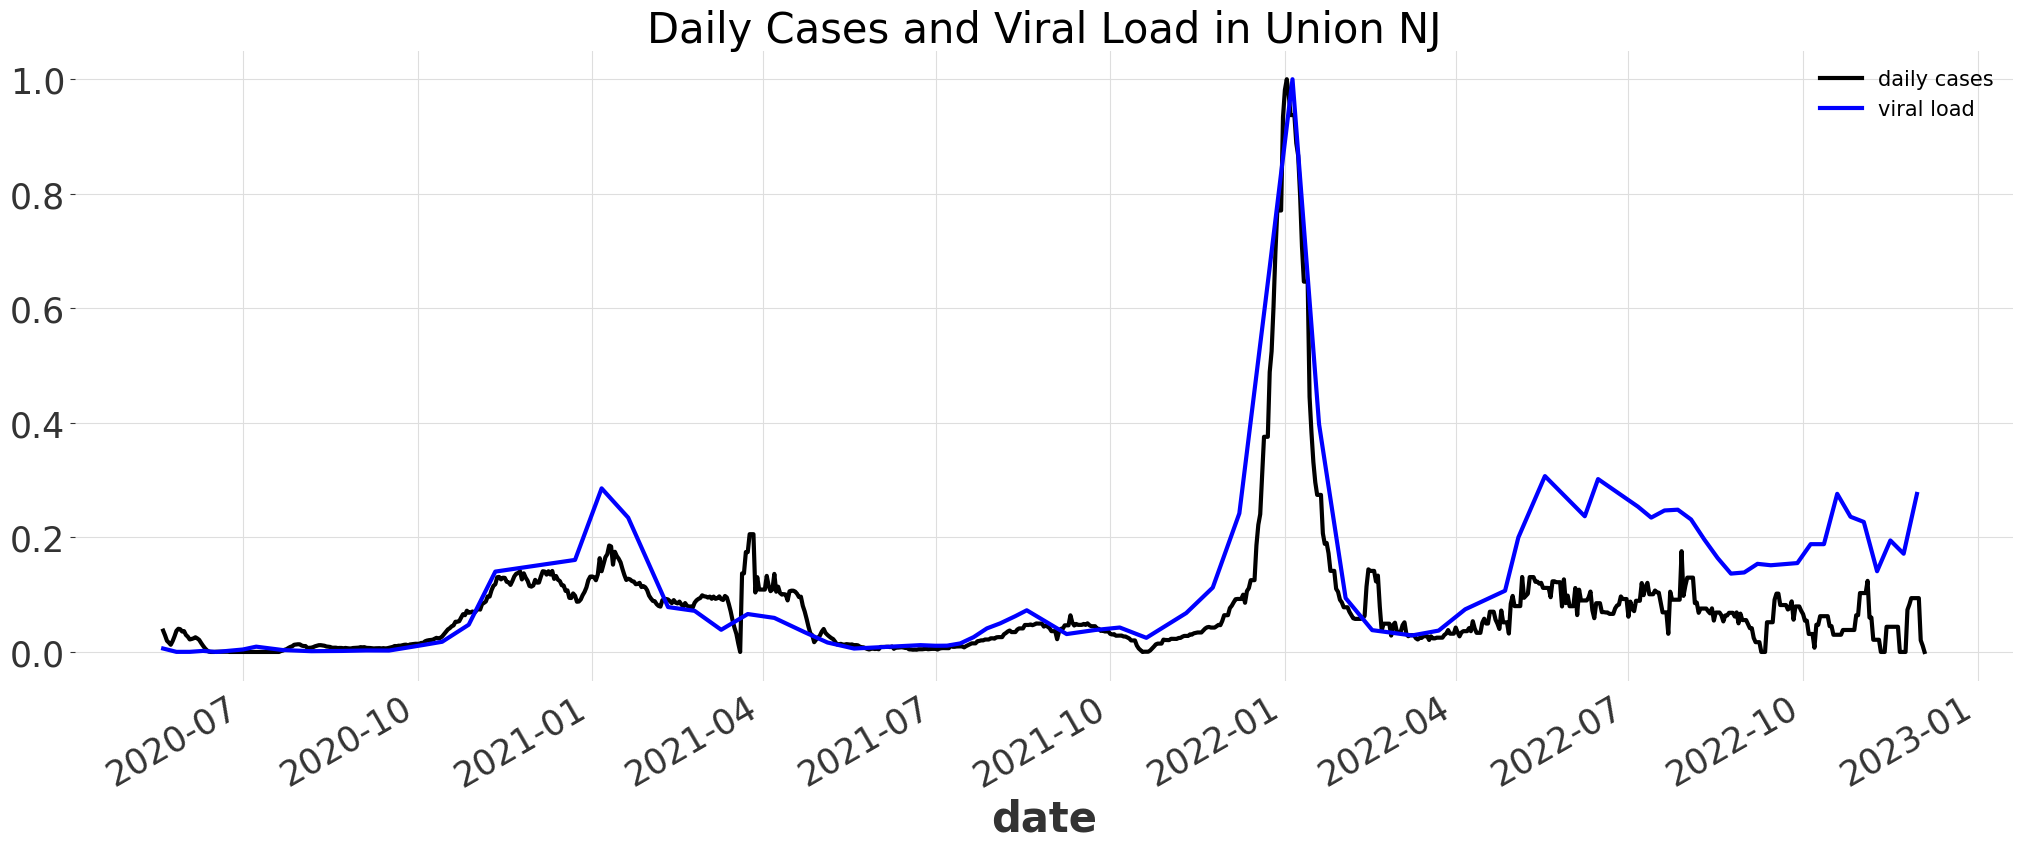

In [ ]:
k=0
fig, axes = plt.subplots(1, 1, figsize = (25, 9))
plt.rcParams.update({'font.size': 30, 'font.weight':'normal', 'font.family': 'times new roman'})
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.8, wspace=None, hspace=0.4)

counties_instances[k].cases_scaled.plot(label='Daily Cases', linewidth=3, color='black')
counties_instances[k].viral_scaled.plot(label='Viral Load', linewidth=3, color='blue')
axes.set_title('Daily Cases and Viral Load in Union NJ', fontsize=30)
axes.legend(['daily cases', 'viral load'], fontsize=15)
plt.gcf().subplots_adjust(bottom=0.1)

# Modeling

We use [Darts](https://unit8co.github.io/darts/index.html) package to train the [TFT](https://arxiv.org/abs/1912.09363) model.

## **TFT** with viral load

Check out the [documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tft_model.html) of the TFTModel for more information about the parameters.

In [ ]:
# if you want to retrain the models you just have to uncomment the lines below and train you model. Otherwise just run the last line.

loss_logger_tft = LossLogger()

tft = TFTModel(
    input_chunk_length=30,
    output_chunk_length=10,
    hidden_size=16,
    lstm_layers=1,
    batch_size=64,
    n_epochs=200,
    dropout=0.3,
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    likelihood=GaussianLikelihood(),
    nr_epochs_val_period=1,
    pl_trainer_kwargs={"callbacks": [loss_logger_tft]},
    model_name='TFT-with-covars',
    force_reset=True,
    save_checkpoints=True
)

# # fit the model with past and future covariates
tft.fit(
    series               = train_list_ts,
    val_series           = val_list_ts,
    future_covariates    = fut_covar_ts,
    past_covariates      = past_only_covar_ts,
    val_future_covariates= fut_covar_ts,
    val_past_covariates  = past_only_covar_ts,
    num_loader_workers   = 4,
    verbose=True
)

# if you want to use the pretrained model you just need to save them from GitHub repo to your machine and run the line below

tft = TFTModel.load_from_checkpoint(model_name='TFT-with-covars', best=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Model evaluation

## Prediction

We first try predicting daily cases for the duration of the test period (over 100 days for some counties). In this case, models perform predictions for the first forecast horizon (`output_chunk_length`) which is 10 days. Then, it uses the predicted value for the first forecast horizon to make prediction for the second forecast horizon and so on. It is worth mentioning that the model does not have access to the past covariates past the training period.

In [ ]:
n_samples = 200
low_q = 0.05
high_q = 0.95

smape_dict = {'TFT':[]}
mae_dict   = {'TFT':[]}

pred_tft          = []

for i in range(1):
    print('County {}'.format(counties_instances[i].county, i))
    n_days_pred = len(counties_instances[i].cases_scaled_test)
    
    pred_tft.append(tft.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=past_only_covar_ts[i], future_covariates=fut_covar_ts[i], num_samples=n_samples))

    smape_dict['TFT'].append(smape_calc(counties_instances[i].cases_scaled_test, pred_tft[i], counties_instances[i].cases_scalers))
    mae_dict['TFT'].append(mae_calc(counties_instances[i].cases_scaled_test, pred_tft[i], counties_instances[i].cases_scalers))

County Union County, NJ


Predicting: 0it [00:00, ?it/s]

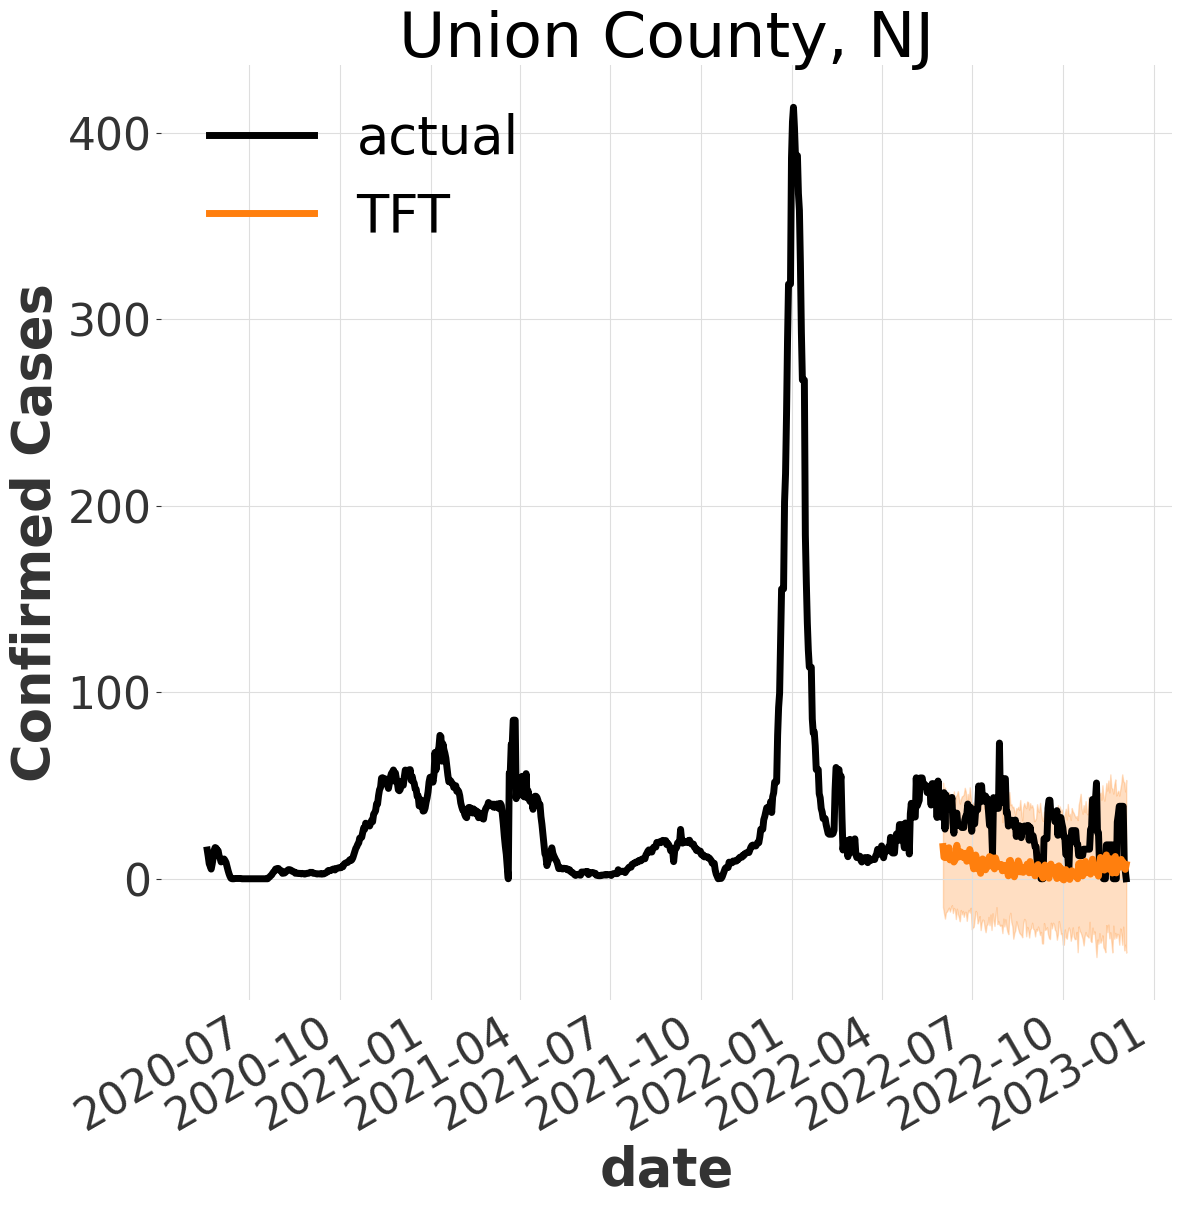

In [ ]:
fig=plt.figure(figsize=[60, 60])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 38, 'font.weight':'normal'})

for i in range(1):
    axis = fig.add_subplot(4,4,i+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.25)
    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="actual", ax=axis, linewidth=5)
    counties_instances[i].cases_scalers.inverse_transform(pred_tft[i]).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:orange', ax=axis, linewidth=5)
    
    axis.legend()
    axis.set_title(counties_instances[i].county)
    
    if i%3 == 0:
        axis.set_ylabel('Confirmed Cases')

plt.show()

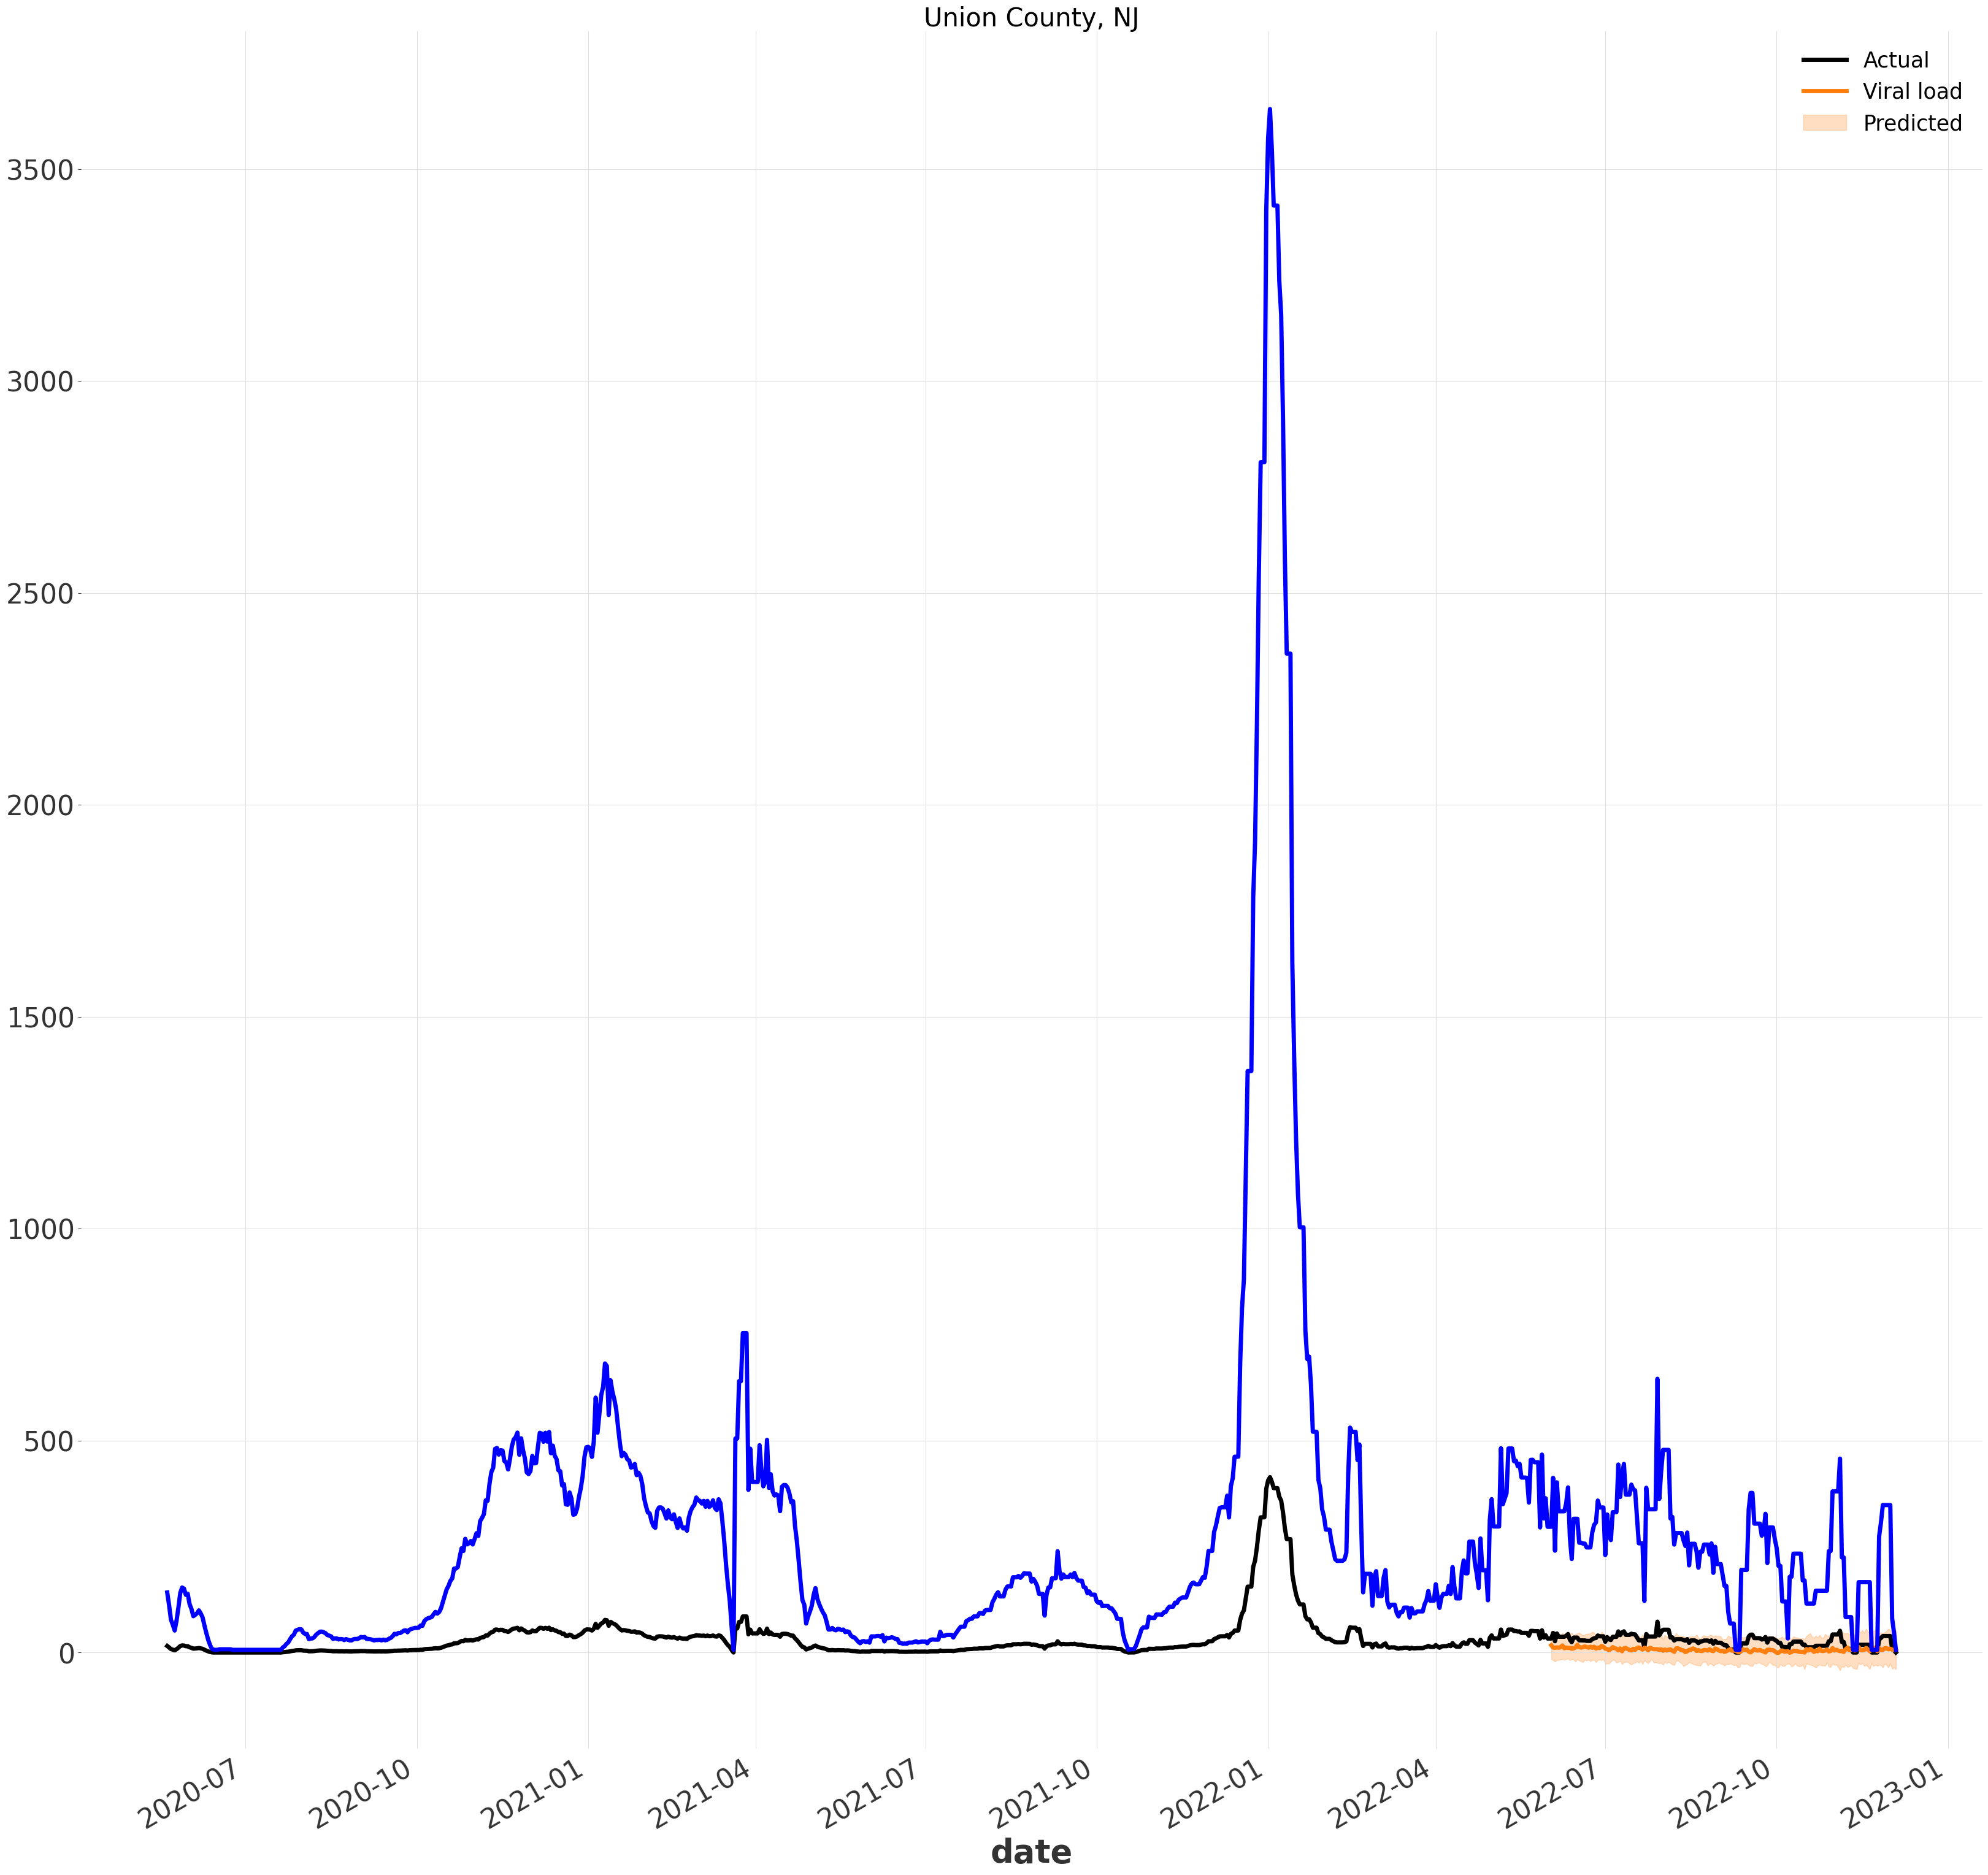

In [ ]:
k=0
fig, axes = plt.subplots(1, 1, figsize = (40, 40))
plt.rcParams.update({'font.size': 50, 'font.weight':'normal', 'font.family': 'times new roman'})
plt.subplots_adjust(left=None, bottom=0.15, right=None, top=0.8, wspace=None, hspace=0.4)

counties_instances[k].cases_scalers.inverse_transform(counties_instances[k].cases_scaled).plot(label="Actual", linewidth=5)
counties_instances[k].cases_scalers.inverse_transform(pred_tft[k]).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:orange', linewidth=5)
counties_instances[k].viral_scalers.inverse_transform(counties_instances[k].cases_scaled).plot(label="Viral", linewidth=5, c='tab:blue')

axes.set_title('Union County, NJ', fontsize=30)
plt.gcf().subplots_adjust(bottom=0.1)

Predicting: 0it [00:00, ?it/s]

TFT - SMAPE:  117.93563463323751


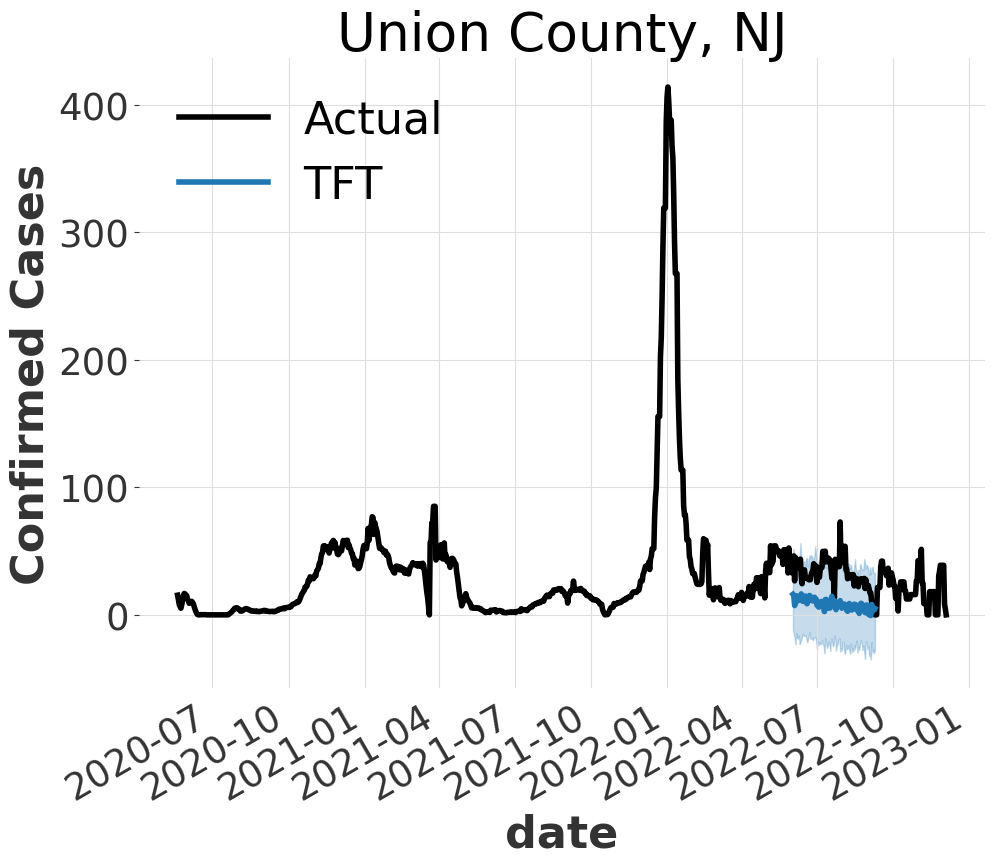

In [ ]:
#- Test

n_days_pred = 100
n_samples = 200
low_q = 0.05
high_q = 0.95

fig=plt.figure(figsize=[24, 20])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 32, 'font.weight':'normal'})

for j, i in enumerate([0]):
    axis = fig.add_subplot(2,2,j+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.35)
    
    pred_tft = tft.predict(n_days_pred, series=counties_instances[i].cases_scaled_val, past_covariates=past_only_covar_ts[i], future_covariates=fut_covar_ts[i], num_samples=n_samples)    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="Actual", ax=axis, linewidth=4, c='k')
    counties_instances[i].cases_scalers.inverse_transform(pred_tft).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:blue', ax=axis, linewidth=4)
    
    print('TFT - SMAPE: ', smape_calc(counties_instances[i].cases_scaled_test, pred_tft, counties_instances[i].cases_scalers))    
    axis.legend()
    axis.set_title(counties_instances[i].county)
    
    if j%2 == 0:
        axis.set_ylabel('Confirmed Cases')

# plt.savefig('./figs/TFT/Jan-10/TFT-noTFT-comp.png', bbox_inches='tight', dpi=400)
plt.show()

## Backtesting

Despite the raw prediction, backtesting shifts the look-back window past the training period intead of prediction the entire test period at once. It is a more realistic evaluation of the model with the availability of new data. **It is our selected method for evaluating the models and making predictions and producing results for the [paper](https://arxiv.org/abs/2212.08798)**

In [ ]:
params = {'hr': 10, 'strd': 10, 'start_ratio': 0.8, 'n_samples': 200, 'low_q': 0.05, 'high_q': 0.95, 'is_retrain':False}

hr = params['hr']
strd = params['strd']
start_ratio = params['start_ratio']
n_samples = params['n_samples']
low_q = params['low_q']
high_q = params['high_q']
is_retrain = params['is_retrain']
    
mae_dict      = {'TFT':[]}
cov_dict      = {'TFT':[]}
smape_dict    = {'TFT':[]}

DeepTCN_backtest     = []
TFT_backtest         = []

for k in range(len(fut_covar_ts)):
    print('{},\t{}/{}'.format(counties_instances[k].county, k+1, len(fut_covar_ts)))

    backtest_tft = tft.historical_forecasts(
        series=counties_instances[k].cases_scaled,
        future_covariates=fut_covar_ts[k],
        past_covariates=past_only_covar_ts[k],
        start=start_ratio,
        num_samples=n_samples,
        forecast_horizon=hr,
        stride=strd,
        overlap_end=False,
        last_points_only=False,
        retrain=is_retrain,
        verbose=False,
    )
    TFT_backtest.append(concatenate(backtest_tft, ignore_time_axis=True))
    print('TFT with viral load is done!')

Union County, NJ,	1/1
TFT with viral load is done!


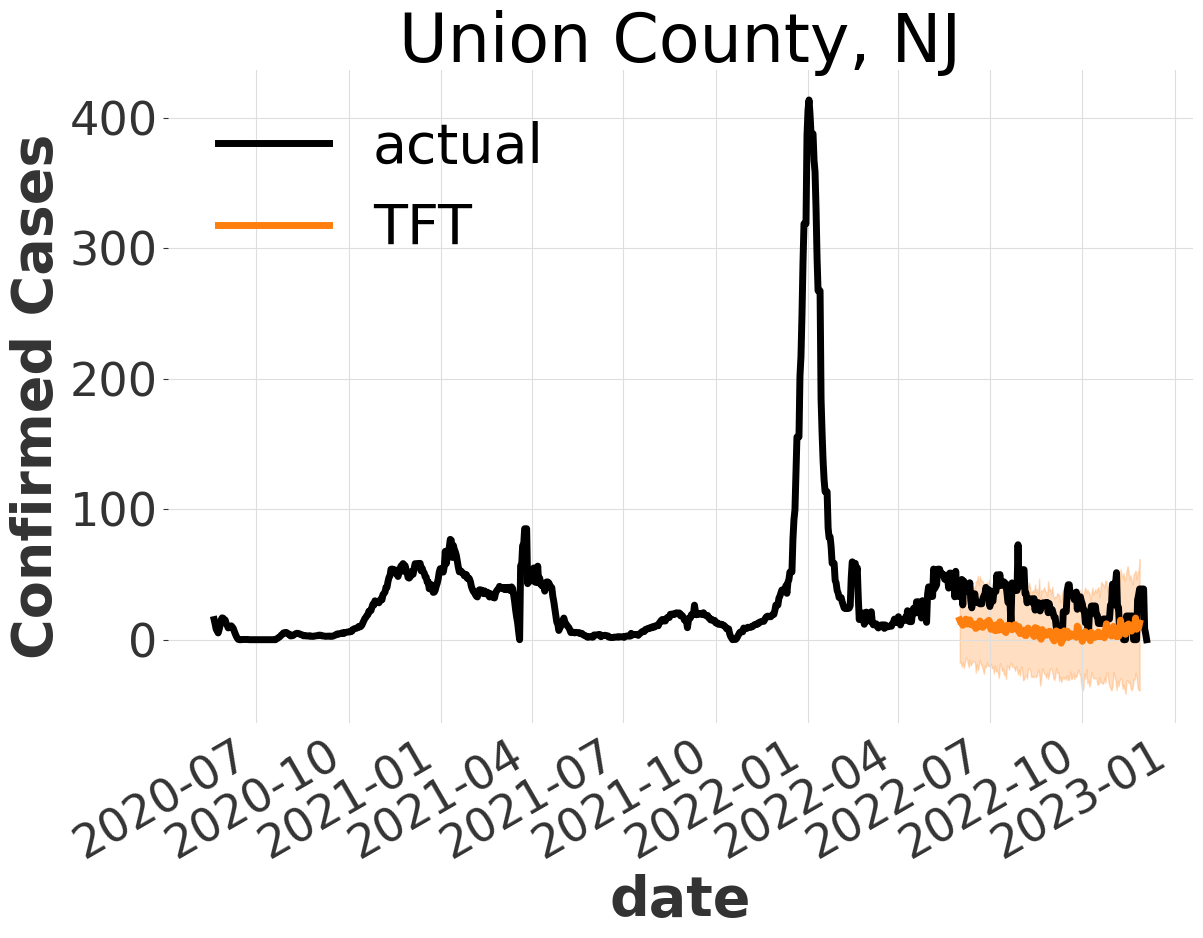

In [ ]:
fig=plt.figure(figsize=[45, 60])
plt.rcParams.update({'font.family':'times new roman', 'font.size': 40, 'font.weight':'normal'})

for i in range(1):
    axis = fig.add_subplot(5,3,i+1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.85, wspace=None, hspace=0.45)
    
    counties_instances[i].cases_scalers.inverse_transform(counties_instances[i].cases_scaled).plot(label="actual", ax=axis, linewidth=5)
    counties_instances[i].cases_scalers.inverse_transform(TFT_backtest[i]).plot(label="TFT", low_quantile=low_q, high_quantile=high_q, c='tab:orange', ax=axis, linewidth=5)
    
    axis.legend()
    axis.set_title(counties_instances[i].county)
    
    if i%3 == 0:
        axis.set_ylabel('Confirmed Cases')

# plt.savefig('./figs/TFT/Jan-10/backtest_ALL_3*5.png', bbox_inches='tight', dpi=200)
plt.show()

## Model Evaluation

We use three evaluation metrics, mean absolute error (MAE), symmetric mean absolute percentage error (SMAPE), and coefficient of variation (CV). We calculate them for training counties and holdout counties separately.

### Holdout Counties

In [ ]:
mae_dict      = {'TFT':[]}
cov_dict      = {'TFT':[]}
smape_dict    = {'TFT':[]}

# for k in range(len(fut_covar_ts)):
for k in range(1):
    
    target_county = counties_instances[k]
        
    smape_dict['TFT'].append(smape_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    mae_dict['TFT'].append(mae_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    cov_dict['TFT'].append(cov_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))


cols=['Metric', 'TFT']
Models_eval = pd.DataFrame(columns=cols)

Models_eval['Metric'] = ['mae', 'cov', 'smape']

for i in cols[1:]:
    Models_eval.loc[0,i] = round(np.mean(mae_dict[i]), 3)
    Models_eval.loc[1,i] = round(np.mean(cov_dict[i]), 3)
    Models_eval.loc[2,i] = round(np.mean(smape_dict[i]), 3)

print('Holdout Counties:')
Models_eval

Holdout Counties:


,Metric,TFT
0,mae,21.39
1,cov,75.567
2,smape,123.968


### Training Counties

In [ ]:
mae_dict      = {'TFT':[]}
cov_dict      = {'TFT':[]}
smape_dict    = {'TFT':[]}

# for k in range(len(fut_covar_ts)):
for k in range(1):
    
    target_county = counties_instances[k]
        
    smape_dict['TFT'].append(smape_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    mae_dict['TFT'].append(mae_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))

    cov_dict['TFT'].append(cov_calc(TFT_backtest[k], target_county.cases_scaled, target_county.cases_scalers))


cols=['Metric', 'TFT']
Models_eval = pd.DataFrame(columns=cols)

Models_eval['Metric'] = ['mae', 'cov', 'smape']

for i in cols[1:]:
    Models_eval.loc[0,i] = round(np.mean(mae_dict[i]), 3)
    Models_eval.loc[1,i] = round(np.mean(cov_dict[i]), 3)
    Models_eval.loc[2,i] = round(np.mean(smape_dict[i]), 3)

print('Training Counties:')
Models_eval

Training Counties:


,Metric,TFT
0,mae,21.39
1,cov,75.567
2,smape,123.968


## Error per County

In [ ]:
mae_df = pd.DataFrame(mae_dict)
mae_df['metric'] = 'mae'
mae_df['county'] = county_names[:11]

cov_df = pd.DataFrame(cov_dict)
cov_df['metric'] = 'cov'
cov_df['county'] = county_names[:11]

smape_df = pd.DataFrame(smape_dict)
smape_df['metric'] = 'smape'
smape_df['county'] = county_names[:11]

my_dat = pd.concat([mae_df, cov_df, smape_df], axis=0, ignore_index=True)
my_dat

my_dat = my_dat.melt(id_vars=['metric', 'county'], value_vars=['TFT'])
my_dat

,metric,county,variable,value
0,mae,Union,TFT,21.390375
1,cov,Union,TFT,75.566773
2,smape,Union,TFT,123.967939
